<a href="https://colab.research.google.com/github/Beerschtein/PyTorch/blob/main/HW_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание 7

1. Попробуйте обучить нейронную сеть GRU/LSTM для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

2. Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

У кого нет возможности работать через каггл (нет верификации), то можете данные взять по ссылке: https://disk.yandex.ru/d/LV1cYS1orMyRWA

### Скачаем датасет и подготовим данные

In [1]:
!wget 'https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1sVla-Yr8ysd2W8m3xNUCMDb2MCDcn0VY' -O twitter_sentiment.zip

--2022-09-02 07:40:03--  https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1sVla-Yr8ysd2W8m3xNUCMDb2MCDcn0VY
Resolving drive.google.com (drive.google.com)... 142.251.12.139, 142.251.12.100, 142.251.12.113, ...
Connecting to drive.google.com (drive.google.com)|142.251.12.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-18-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/o3arj2klsrho5fmvp705k6fast801gin/1662104400000/06840004559052771215/*/1sVla-Yr8ysd2W8m3xNUCMDb2MCDcn0VY?e=download&uuid=46e8c8cb-aba8-4ed5-8d94-d548a4328efb [following]
--2022-09-02 07:40:06--  https://doc-00-18-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/o3arj2klsrho5fmvp705k6fast801gin/1662104400000/06840004559052771215/*/1sVla-Yr8ysd2W8m3xNUCMDb2MCDcn0VY?e=download&uuid=46e8c8cb-aba8-4ed5-8d94-d548a4328efb
Resolving doc-00-18-docs.googleusercontent.com (doc-00-18-docs.googleusercontent.com)... 

In [2]:
!unzip twitter_sentiment.zip

Archive:  twitter_sentiment.zip
  inflating: test.csv                
  inflating: train.csv               


In [4]:
!pip install stop-words pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 4.4 MB/s 
     |████████████████████████████████| 8.2 MB 19.5 MB/s 
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32911 sha256=d226bc3ec95a14b9c11ac4dad484eb1f9da2fcdeb0aff2ee79139187ddcdad68
  Stored in directory: /root/.cache/pip/wheels/fb/86/b2/277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=340f71ed7a78fb8465c421ebd566f20f5584faf5da16d49af77fd820301f37b0
  Stored in directory: /root/.cache/pip/wheels/72/b0/3f/1d95f96ff986c7dfffe46ce2be4062f38ebd04b506c77c81b9
Successfully built stop-words docopt


In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from string import punctuation
from stop_words import get_stop_words
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from pymorphy2 import MorphAnalyzer
import re

In [6]:
df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [7]:
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [9]:
df.duplicated().sum()

0

In [10]:
df['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [11]:
fractions = np.array([0.7, 0.3])
# shuffle your input
df = df.sample(frac=1) 
# split into 2 parts
df_train, df_val = np.array_split(
    df, (fractions[:-1].cumsum() * len(df)).astype(int))

In [12]:
df_train.head()

,id,label,tweet
12193,12194,0,@user green has been warned. he chronically do...
3139,3140,0,thats right !! #wedding #pay #weddingpay #bi #...
23555,23556,0,finished the gardening..... !?!?!
2555,2556,0,dinner tiiime! âð»ï¸ðâð» #roadtrip...
20036,20037,0,"@user well, i have a creeper and they send scr..."


In [13]:
df_train['label'].value_counts()

0    20794
1     1579
Name: label, dtype: int64

In [14]:
df_val['label'].value_counts()

0    8926
1     663
Name: label, dtype: int64

In [15]:
sw = set(get_stop_words('en'))
# sw

In [16]:
puncts = set(punctuation)
# puncts

## Для лемматизации английских слов применим WordNetLemmatizer из библиотеки nltk

In [23]:
import nltk
from nltk.stem import WordNetLemmatizer 

nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [24]:
lemmatizer = WordNetLemmatizer()

In [25]:
print(lemmatizer.lemmatize("bats"))

bat


In [36]:
def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in puncts)
    txt = txt.lower()
    # txt = re.sub("не\s", "не", txt)
    txt = re.sub('@user', '', txt)
    # txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    txt = [lemmatizer.lemmatize(word) for word in txt.split() if word not in sw]
    return " ".join(txt)

In [42]:
df_train['tweet'].iloc[:1].values

array(['@user green has been warned. he chronically does this.  he should be suspended for the series.  but, business is more impoant.  '],
      dtype=object)

In [43]:
df_train['tweet'].iloc[:1].apply(preprocess_text).values

array(['user green warned chronically suspended series business impoant'],
      dtype=object)

In [44]:
from tqdm import tqdm 
tqdm.pandas()

df_train['tweet'] = df_train['tweet'].progress_apply(preprocess_text)
df_val['tweet'] = df_val['tweet'].progress_apply(preprocess_text)

100%|██████████| 9589/9589 [00:00<00:00, 19920.31it/s]


In [45]:
train_corpus = " ".join(df_train["tweet"])
train_corpus = train_corpus.lower()

In [46]:
nltk.download("punkt")

tokens = word_tokenize(train_corpus)
tokens[:5]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['user', 'green', 'warned', 'chronically', 'suspended']

In [47]:
tokens_filtered = [word for word in tokens if word.isalnum()]

### Зададим необходимые параметры:

In [74]:
max_words = 4000
max_len = 20
num_classes = 1

# Training
epochs = 10
batch_size = 512
print_batch_n = 100

In [75]:
from nltk.probability import FreqDist

dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  # вычитание 1 для padding
len(tokens_filtered_top)

3999

In [76]:
tokens_filtered_top[:10]

['user', 'day', 'love', 'happy', 'u', 'amp', 'just', 'will', 'life', 'time']

In [77]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}
# vocabulary

In [78]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding

In [79]:
%%time
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["tweet"]])
x_val = np.asarray([text_to_sequence(text, max_len) for text in df_val["tweet"]])

CPU times: user 3.12 s, sys: 10.7 ms, total: 3.13 s
Wall time: 3.14 s


In [80]:
x_train.shape

(22373, 20)

In [81]:
df_train['tweet'].iloc[0]

'user green warned chronically suspended series business impoant'

In [82]:
x_train[0]

array([   1,  493, 3790,  761,  330,  424,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0])

In [83]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [84]:
class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [85]:
train_dataset = DataWrapper(x_train, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, df_val['label'].values)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [86]:
for x, l in train_loader:
    print(x.shape)
    print(l.shape)
    print(l[0])
    break

torch.Size([512, 20])
torch.Size([512])
tensor(0)


In [87]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## LSTM. Long Short-Term Memory

In [88]:
from torch import nn

class LSTMFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, ht = self.lstm(x)
       
        if self.use_last:
            last_tensor = lstm_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(lstm_out[:,:], dim=1)
    
        out = self.linear(last_tensor)
        # print(out.shape)
        return torch.sigmoid(out)

In [89]:
lstm_init = LSTMFixedLen(max_words, 128, 20, use_last=False)
optimizer = torch.optim.Adam(lstm_init.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [90]:
print(lstm_init)
print("Parameters:", sum([param.nelement() for param in lstm_init.parameters()]))

LSTMFixedLen(
  (embeddings): Embedding(4000, 128, padding_idx=0)
  (lstm): LSTM(128, 20, num_layers=2, batch_first=True)
  (linear): Linear(in_features=20, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 527381


In [91]:
lstm_init = lstm_init.to(device)
lstm_init.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):  
    lstm_init.train()
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = lstm_init(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    # выводим статистику о процессе обучения
    lstm_init.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

    # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = lstm_init(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
        
print('Training is finished!')

Epoch [1/10]. Step [44/44]. Loss: 0.377. Acc: 0.929. Test loss: 0.253. Test acc: 0.931
Epoch [2/10]. Step [44/44]. Loss: 0.269. Acc: 0.929. Test loss: 0.083. Test acc: 0.931
Epoch [3/10]. Step [44/44]. Loss: 0.159. Acc: 0.929. Test loss: 0.073. Test acc: 0.931
Epoch [4/10]. Step [44/44]. Loss: 0.222. Acc: 0.929. Test loss: 0.072. Test acc: 0.931
Epoch [5/10]. Step [44/44]. Loss: 0.166. Acc: 0.934. Test loss: 0.154. Test acc: 0.942
Epoch [6/10]. Step [44/44]. Loss: 0.149. Acc: 0.944. Test loss: 0.110. Test acc: 0.950
Epoch [7/10]. Step [44/44]. Loss: 0.118. Acc: 0.953. Test loss: 0.188. Test acc: 0.951
Epoch [8/10]. Step [44/44]. Loss: 0.095. Acc: 0.958. Test loss: 0.086. Test acc: 0.952
Epoch [9/10]. Step [44/44]. Loss: 0.117. Acc: 0.959. Test loss: 0.237. Test acc: 0.949
Epoch [10/10]. Step [44/44]. Loss: 0.089. Acc: 0.963. Test loss: 0.014. Test acc: 0.952
Training is finished!


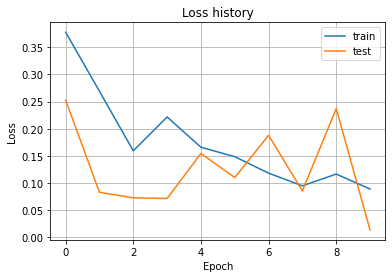

In [92]:
import matplotlib.pyplot as plt

plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend();

In [103]:
max_words = 4000
max_len = 20
num_classes = 1

# Training
epochs = 7
batch_size = 512
print_batch_n = 100

# GRU. Gated Recurrent Unit


In [104]:
from torch import nn

class GRUFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=2, batch_first=True, )
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        gru_out, ht = self.gru(x)
       
        if self.use_last:
            last_tensor = gru_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(gru_out[:,:], dim=1)
    
        out = self.linear(last_tensor)
        return torch.sigmoid(out)

In [105]:
gru_init = GRUFixedLen(max_words, 128, 20, use_last=False)
optimizer = torch.optim.Adam(gru_init.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [106]:
print(gru_init)
print("Parameters:", sum([param.nelement() for param in gru_init.parameters()]))

GRUFixedLen(
  (embeddings): Embedding(4000, 128, padding_idx=0)
  (gru): GRU(128, 20, num_layers=2, batch_first=True)
  (linear): Linear(in_features=20, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 523541


In [107]:
gru_init = gru_init.to(device)
gru_init.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs): 
    gru_init.train() 
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = gru_init(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    # выводим статистику о процессе обучения
    gru_init.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
          f'Step [{i + 1}/{len(train_loader)}]. ' \
          f'Loss: {loss:.3f}. ' \
          f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

    # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = gru_init(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
            
print('Training is finished!')

Epoch [1/7]. Step [44/44]. Loss: 0.305. Acc: 0.927. Test loss: 0.506. Test acc: 0.931
Epoch [2/7]. Step [44/44]. Loss: 0.249. Acc: 0.929. Test loss: 0.573. Test acc: 0.931
Epoch [3/7]. Step [44/44]. Loss: 0.240. Acc: 0.929. Test loss: 0.064. Test acc: 0.931
Epoch [4/7]. Step [44/44]. Loss: 0.175. Acc: 0.932. Test loss: 0.063. Test acc: 0.940
Epoch [5/7]. Step [44/44]. Loss: 0.178. Acc: 0.945. Test loss: 0.061. Test acc: 0.948
Epoch [6/7]. Step [44/44]. Loss: 0.122. Acc: 0.953. Test loss: 0.119. Test acc: 0.949
Epoch [7/7]. Step [44/44]. Loss: 0.147. Acc: 0.957. Test loss: 0.030. Test acc: 0.953
Training is finished!


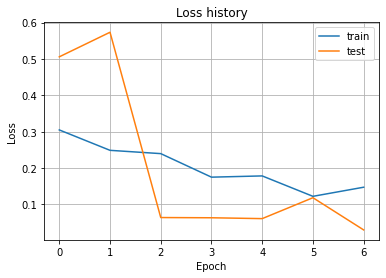

In [108]:
import matplotlib.pyplot as plt

plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend();

### GRU в этом тесте показала чуть более лучший результат, чем LSTM. Однако у GRU более равномерное падение loss. Возможно, что при увеличении эпох обучения это снижение продолжится. 

### Для улучшения работы сетей увеличил параметр max_words = 4000 и применил лемматизатор WordNetLemmatizer для английских слов из библиотеки nltk. Как и было ожидаемо, рекурентные сети показали результат на этом датасете существенно лучший, чем обычная CNN.